In [1]:
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import xmltodict

# Look at images and their keypoints

All images of shells should be cropped and in a folder called `cropped_images` and keypoint annotations should be in a folder called `keypoint_annotations`.

In [2]:
# Get shell keypoints.
def get_keypoints(xml_path, image_name):
    """
    Parses keypoints from xml for a specific image.

    Arguments:
        xml_path: path to the xml created by CVAT.
        image_name: name of the image annotated by CVAT.

    Returns:
        tuple: ([corners that make the scutes perimeter], [the centers of the three scutes]).
    """

    with open(xml_path, 'r') as f:
        xml_dict = xmltodict.parse(f.read())
        centers = []
        corners = []
        for img_annotation in xml_dict['annotations']['image']:
            if image_name == img_annotation['@name']:
                if len(img_annotation['points']) > 1:
                    for label in img_annotation['points']:
                        if label['@label'] == 'centers':
                            for point in label['@points'].split(";"):
                                centers.append(tuple(round(float(coord ))for coord in point.split(',')))
                        if label['@label'] == 'corners':
                            for point in label['@points'].split(";"):
                                corners.append(tuple(round(float(coord ))for coord in point.split(',')))

    return corners, centers

In [3]:
# Get image names and shell keypoints.
img_dir = os.path.join('..', 'cropped_images')
image_names = []
xml_path = os.path.join('..', 'keypoint_annotations.xml')
keypoints = []
for file in os.listdir(img_dir):
    if os.path.splitext(file)[1] == '.jpg':
        image_names.append(file)
        keypoints.append(get_keypoints(xml_path, file))

print(f'length of images: {len(image_names)}')
print(f'length of keypoints: {len(keypoints)}')

length of images: 81
length of keypoints: 81


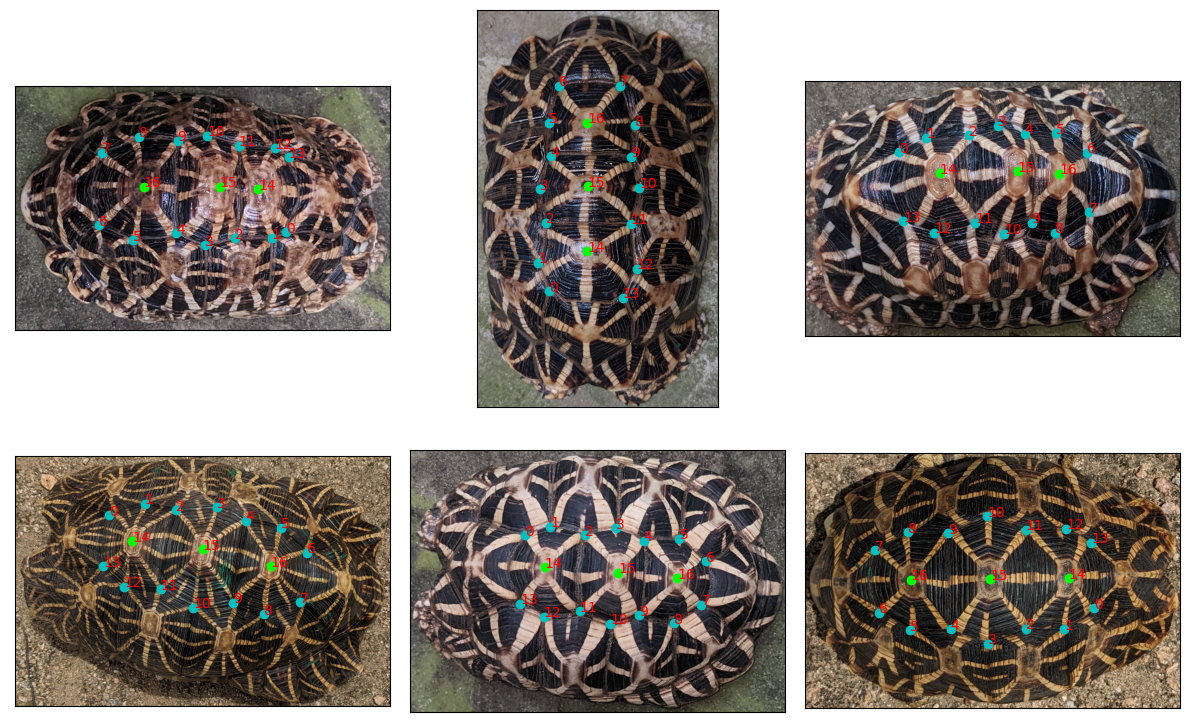

In [4]:
# Plot a sample of images and their keypoints.
fig = plt.figure(figsize=(12, 8))
axes = fig.subplots(2, 3)
flatten_axes = axes.flatten()
random_image_idx = random.sample(range(len(image_names)), k=len(flatten_axes))

for e, i in enumerate(random_image_idx):

    # Read and plot image.
    image = img.imread(os.path.join(img_dir, image_names[i]))
    flatten_axes[e].imshow(image)
    flatten_axes[e].get_xaxis().set_visible(False)
    flatten_axes[e].get_yaxis().set_visible(False)

    # Plot keypoints.
    points = np.concatenate(keypoints[i])
    x, y  = points[:, 0], points[:, 1]
    flatten_axes[e].scatter(x[:-3], y[:-3], c='c')
    flatten_axes[e].scatter(x[-3:], y[-3:], c='lime')

    # Numerate the points.
    for point_idx, (x_i, y_i) in enumerate(zip(x, y)):
        flatten_axes[e].text(x_i, y_i, point_idx, c='r')

plt.tight_layout()
plt.show()

# Scute Template

Create a template, cut the scutes into triangles, and transform those triangles into the template.

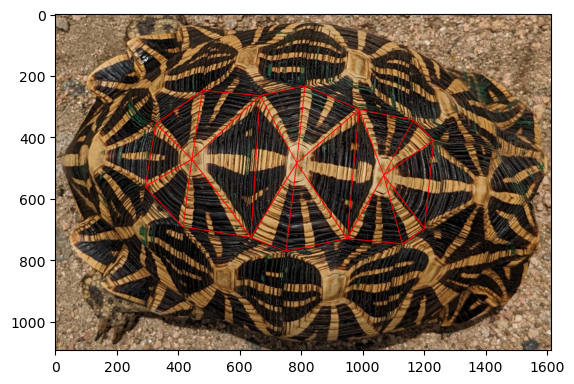

In [5]:
# Connect the corners of each scute to their respective center.
index = 0
image = img.imread(os.path.join(img_dir, image_names[index]))
corners, centers = keypoints[index]

# Take all of the keypoint indexes and put then into their respective scute.
scute1 = [0, 1, 2, 11, 12, 13]
scute2 = [2, 3, 4, 9, 10, 11]
scute3 = [4, 5, 6, 7, 8, 9]
scute_idxs = [scute1, scute2, scute3]

# Create the triangles for each scute.
triangles = []
for i in range(len(scute_idxs)):
    left = -1
    for corner_idx in scute_idxs[i]:
        x1, y1 = corners[scute_idxs[i][left]]
        x2, y2 = corners[corner_idx]
        x3, y3 = centers[i]
        triangles.append([x1, y1, x2, y2, x3, y3])
        left += 1

# Draw the triangles.
for triangle in triangles:
    pt1 = triangle[0], triangle[1]
    pt2 = triangle[2], triangle[3]
    pt3 = triangle[4], triangle[5]
    cv2.line(image, pt1, pt2, (255, 0, 0), 2)
    cv2.line(image, pt2, pt3, (255, 0, 0), 2)
    cv2.line(image, pt3, pt1, (255, 0, 0), 2)

plt.imshow(image)
plt.show()

In [6]:
# This is the template we will use.
TEMPLATE = np.float32([
    (0.725, 0.05), (0.95, 0.20),
    (0.725, 0.35), (0.95, 0.50),
    (0.725, 0.65), (0.95, 0.80),
    (0.725, 0.95), (0.275, 0.95),
    (0.05, 0.80),  (0.275, 0.65),
    (0.05, 0.50),  (0.275, 0.35),  
    (0.05, 0.20), (0.275, 0.05),
    (0.50, 0.20),
    (0.50, 0.50),
    (0.50, 0.80)])

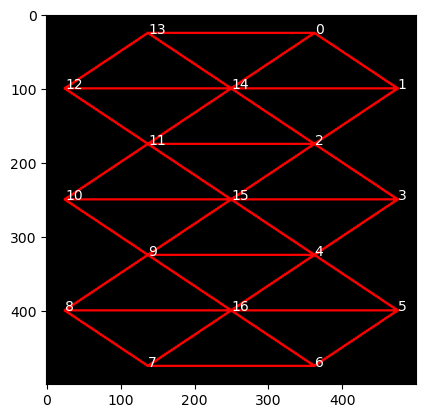

In [7]:
# Visualize the template.
# Create a blank canvas.
length = 500
template = np.zeros((length, length, 3), dtype=np.uint8)

# Create the triangles for each scute.
temp_triangles = []
for i in range(len(scute_idxs)):
    left = -1
    for corner_idx in scute_idxs[i]:
        x1, y1 = TEMPLATE[scute_idxs[i][left]]
        x2, y2 = TEMPLATE[corner_idx]
        x3, y3 = TEMPLATE[-3+i]
        temp_triangles.append([x1, y1, x2, y2, x3, y3])
        left += 1

# Draw the triangles.
for triangle in np.multiply(temp_triangles, length).astype(np.int32):
    pt1 = triangle[0], triangle[1]
    pt2 = triangle[2], triangle[3]
    pt3 = triangle[4], triangle[5]
    cv2.line(template, pt1, pt2, (255, 0, 0), 2)
    cv2.line(template, pt2, pt3, (255, 0, 0), 2)
    cv2.line(template, pt3, pt1, (255, 0, 0), 2)

for i in range(len(TEMPLATE)):
    x, y = np.multiply(TEMPLATE[i], length)
    plt.text(x, y, i, c='w')

plt.imshow(template)
plt.show()

# Affine Transformations

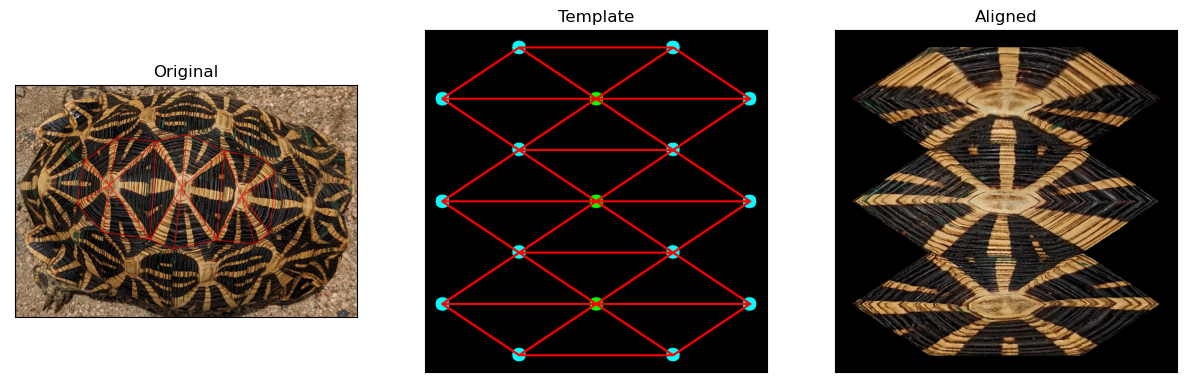

In [8]:
# Read a fresh image in.
index = 0
image = img.imread(os.path.join(img_dir, image_names[index]))
corners, centers = keypoints[index]

# Create the template.
length = 500
template = np.zeros((length, length, 3), dtype=np.uint8)

for x, y in TEMPLATE[:-3]:
    cv2.circle(template, (int(x*length), int(y*length)), radius=int(length/50), color=(0,255,255), thickness=-1)

for x, y in TEMPLATE[-3:]:
    cv2.circle(template, (int(x*length), int(y*length)), radius=int(length/50), color=(0,255,0), thickness=-1)


scute1 = [0, 1, 2, 11, 12, 13]
scute2 = [2, 3, 4, 9, 10, 11]
scute3 = [4, 5, 6, 7, 8, 9]
scute_idxs = [scute1, scute2, scute3]

img_triangles = []
for i in range(len(scute_idxs)):
    left = -1
    for corner_idx in scute_idxs[i]:
        x1, y1 = corners[scute_idxs[i][left]]
        x2, y2 = corners[corner_idx]
        x3, y3 = centers[i]
        img_triangles.append([x1, y1, x2, y2, x3, y3])
        left += 1

aligned = np.zeros(template.shape, np.uint8)
image_copy = image.copy()
scaled_triangles = np.multiply(temp_triangles, length).astype(np.int32)
for img_triangle, scaled_triangle in zip(img_triangles, scaled_triangles):
    # Get the original triangle.
    tr1_pt1 = img_triangle[0], img_triangle[1]
    tr1_pt2 = img_triangle[2], img_triangle[3]
    tr1_pt3 = img_triangle[4], img_triangle[5]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

    # Draw the original triangle.
    cv2.line(image, tr1_pt1, tr1_pt2, (255, 0, 0), 2)
    cv2.line(image, tr1_pt2, tr1_pt3, (255, 0, 0), 2)
    cv2.line(image, tr1_pt3, tr1_pt1, (255, 0, 0), 2)

    # Get a bouding box around the original traingle.
    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle1 = image_copy[y: y+h, x: x+w]
    
    # Fill outside of the cropped triangle with black and inside with white.
    cropped_tr1_mask = np.zeros((h, w), np.uint8)
    points1 = np.array(
        [[tr1_pt1[0]-x, tr1_pt1[1]-y],
        [tr1_pt2[0]-x, tr1_pt2[1]-y],
        [tr1_pt3[0]-x, tr1_pt3[1]-y],]
    )
    cv2.fillConvexPoly(cropped_tr1_mask, points1, 255)

    # Use the mask to cut around the original triangle in its bounding box.
    cropped_triangle1 = cv2.bitwise_and(cropped_triangle1, cropped_triangle1,
                                       mask=cropped_tr1_mask)

    # Get the template triangle.
    tr2_pt1 = scaled_triangle[0], scaled_triangle[1]
    tr2_pt2 = scaled_triangle[2], scaled_triangle[3]
    tr2_pt3 = scaled_triangle[4], scaled_triangle[5]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

    # Draw the template triangle.
    cv2.line(template, tr2_pt1, tr2_pt2, (255, 0, 0), 2)
    cv2.line(template, tr2_pt2, tr2_pt3, (255, 0, 0), 2)
    cv2.line(template, tr2_pt3, tr2_pt1, (255, 0, 0), 2)

    # Get a bouding box around the template traingle.
    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2
    points2 = np.array(
        [[tr2_pt1[0]-x, tr2_pt1[1]-y],
        [tr2_pt2[0]-x, tr2_pt2[1]-y],
        [tr2_pt3[0]-x, tr2_pt3[1]-y],]
    )

    # Affine Transform
    points1 = np.float32(points1)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points1, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle1, M, (w, h), flags=cv2.INTER_NEAREST)

    # Place triangles to match template.
    triangle_area = aligned[y: y+h, x: x+w]
    triangle_area_gray = cv2.cvtColor(triangle_area, cv2.COLOR_BGR2GRAY)

    # Remove the lines
    _, mask_triangles_designed = cv2.threshold(triangle_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    triangle_area = cv2.add(triangle_area, warped_triangle)
    aligned[y: y+h, x: x+w] = triangle_area

# Plot the images.
fig = plt.figure(figsize=(15, 10))
axes = fig.subplots(1, 3)
axes[0].imshow(image), axes[0].set_title('Original')
axes[0].get_xaxis().set_visible(False), axes[0].get_yaxis().set_visible(False)
axes[1].imshow(template), axes[1].set_title('Template')
axes[1].get_xaxis().set_visible(False), axes[1].get_yaxis().set_visible(False)
axes[2].imshow(aligned), axes[2].set_title('Aligned')
axes[2].get_xaxis().set_visible(False), axes[2].get_yaxis().set_visible(False)
plt.show()

In [9]:
from shell_alignment.utils import align_scutes, get_keypoints

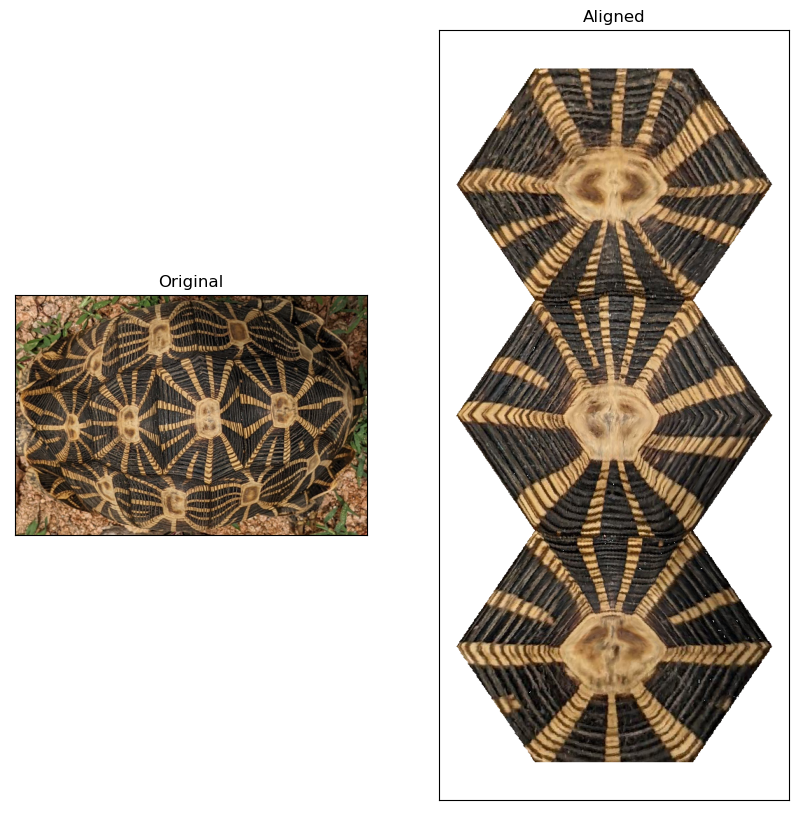

In [10]:
image_path = os.path.join("..", "cropped_images", "PXL_20220723_073310215.MP.jpg")
image = img.imread(image_path)
corners, centers = get_keypoints(xml_path, os.path.split(image_path)[-1])

aligned = align_scutes(image, corners, centers, TEMPLATE, (500, 1100))

fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(1, 2)
axes[0].imshow(image), axes[0].set_title('Original')
axes[0].get_xaxis().set_visible(False), axes[0].get_yaxis().set_visible(False)

axes[1].imshow(aligned), axes[1].set_title('Aligned')
axes[1].get_xaxis().set_visible(False), axes[1].get_yaxis().set_visible(False)
plt.show()